# NYC Airbnb Dataset Analysis

In this notebook we will explore the Airbnb New York dataset and try and predict the price and the neighbourhood group.  
Ideally, we would like to understand how the specific location of a certain housing affects the price given the room type.

In [1]:
%run __base.ipynb

## Imports

In [70]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from math import radians
import numpy as np
from sklearn.metrics.pairwise import haversine_distances
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn_pandas import DataFrameMapper
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

## Constants

In [3]:
# We define the dataset's path
PATH = os.path.join("data", "AB_NYC_2019.csv")

## Exploratory Data Analysis

In [4]:
# We load the dataset from the disk
raw_data = pd.read_csv(PATH)

# We print a random sample 
raw_data.sample(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
4954,3550879,Beautiful Harlem apt with views,17874864,Kayvon,Manhattan,Harlem,40.82140,-73.95675,Shared room,200,1,31,2016-11-01,0.53,1,365
36975,29392681,Cozy Apartment in Upper West Side New York,220414847,Sergio,Manhattan,Upper West Side,40.78818,-73.96796,Entire home/apt,190,3,37,2019-07-01,4.64,1,120
17242,13640690,Studio Apartment Near Central Park/Hell's Kitchen,34915405,Joshua,Manhattan,Hell's Kitchen,40.76751,-73.98483,Entire home/apt,134,1,24,2017-07-01,0.65,1,0
9745,7496720,Artist's Loft,3530591,Nanda,Manhattan,East Village,40.72295,-73.98246,Entire home/apt,135,4,4,2017-02-11,0.09,1,0
21490,17188328,Cozy studio in the heart of the West Village,6375225,Jennifer,Manhattan,West Village,40.73376,-73.99982,Entire home/apt,150,3,0,NaN,NaN,1,0


In [5]:
# We look at the shape of our dataset
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

From the previous two cells we notice two things:  
    - The ```last_review``` and ```reviews_per_month``` variables contain several NaNs.  
    - There are several inconsistencies in the dataset: namely housing that is available 0 days a year, i.e that has its ```availability_365``` set to zero, or that has the ```price``` variable set to zero.   
    - There are unecessary variables for both prediction tasks, such as ```host_name``` and ```name``` ... etc   

Thus we decide to get rid of the inconsistencies, NaNs and unecessary variables.   
Note that for the NaNs we could've proceeded otherwise, by filling the missing data points by the mean (or the median as it is a more robust statistic) or by building models out of the other variables and try to infer them (as there might be correlations !), but given the size of our dataset we choose to drop them. 


In [6]:
# Dropping previously mentionned inconsistencies and NaNs
raw_data = raw_data[(raw_data.availability_365 > 0) & ~(raw_data.reviews_per_month.isna()) & (raw_data.price > 0)]

# Dropping unecessary variables
raw_data = raw_data.drop(columns=["name", "host_id", "host_name"])

In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26147 entries, 0 to 48852
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              26147 non-null  int64  
 1   neighbourhood_group             26147 non-null  object 
 2   neighbourhood                   26147 non-null  object 
 3   latitude                        26147 non-null  float64
 4   longitude                       26147 non-null  float64
 5   room_type                       26147 non-null  object 
 6   price                           26147 non-null  int64  
 7   minimum_nights                  26147 non-null  int64  
 8   number_of_reviews               26147 non-null  int64  
 9   last_review                     26147 non-null  object 
 10  reviews_per_month               26147 non-null  float64
 11  calculated_host_listings_count  26147 non-null  int64  
 12  availability_365                

We start by investigating our endogenous variables:  
    - Price  
    - Neighbourhood Group

<AxesSubplot:ylabel='Density'>

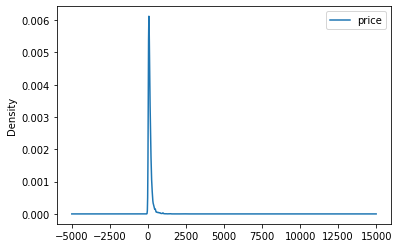

In [8]:
# We plot the distribution of the prices
raw_data[["price"]].plot(kind="kde")

The prices distribution seem be very right skewed, i.e following a log normal distribution due to the large variance in prices. Thus, a logarithmic transformation will help us simplify our asumptions and apply easily our models on the dataset ! 

In [9]:
# We apply the log transformation on the price
raw_data["log_price"] = np.log(1 + raw_data.loc[:, "price"])

Now if we plot again the distribution, it looks a lot better.  
We also compute the kurtosis, which is the fourth standardized moment of a distribution defined by $E[(\frac{X - \mu}{\sigma})^4]$ for a normal distribution it should be 0.   
In our case, when we apply the log transformation it does get pretty close to zero ! 

price        638.584751
log_price      0.887869
dtype: float64

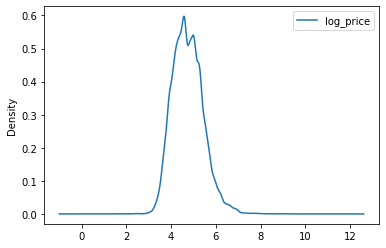

In [10]:
# We plot the log distribution 
raw_data[["log_price"]].plot(kind="kde")

# We compute the Kurtosis for the price and the log price
raw_data[["price", "log_price"]].kurtosis()

Next we explore the relationship between the neighbourhood and price, and the relationship between the room thype and price, by plotting the boxplot of the distributions

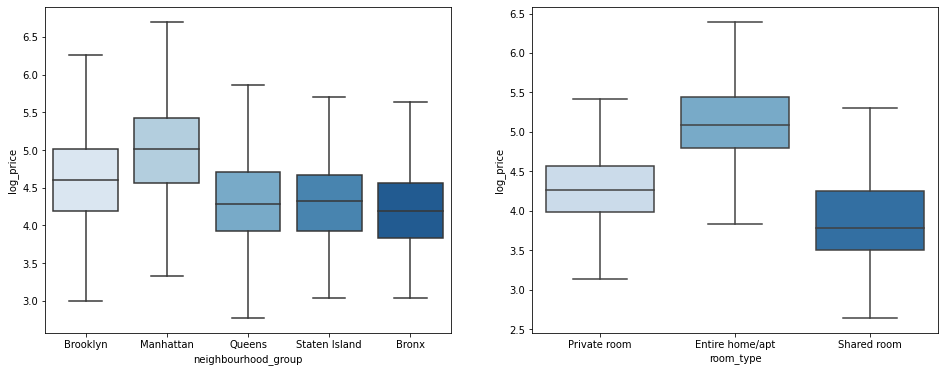

In [11]:
box_plot_features = ['neighbourhood_group', "room_type"]

fig, axes = plt.subplots(1, len(box_plot_features), figsize=(16, 6))

for var, ax in zip(box_plot_features, axes.flat):
    sns.boxplot(x=var,
                y='log_price',
                data=raw_data,
                showfliers=False,
                ax=ax,
                palette='Blues')

There is a clear difference between the following distributions   
However, one might worry that between the difference is not statistically significant between Queens and Staten Island.  
Thus we perform an ANOVA test shows that indeed they are statistically significantly different. In this test we assume homoscedasticity. 

In [12]:
# ANOVA F-test
f_oneway(*[data["log_price"] for grp, data in raw_data.groupby("neighbourhood_group")])

F_onewayResult(statistic=1089.6186431900253, pvalue=0.0)

One thing to note is that our dataset is not balanced along the neighbourhoods 

In [13]:
# We compute the number of housings available per location 
raw_data.groupby(["neighbourhood_group", "neighbourhood"]).count()[["price"]].rename(columns={"price": "count"}).sort_values("count", ascending=False,)

count
neighbourhood_group neighbourhood            
Brooklyn            Bedford-Stuyvesant   2208
                    Williamsburg         1785
Manhattan           Harlem               1508
Brooklyn            Bushwick             1214
Manhattan           Hell's Kitchen       1191
...                                       ...
Staten Island       Rossville               1
                    Silver Lake             1
                    Prince's Bay            1
                    Bull's Head             1
                    Willowbrook             1

[217 rows x 1 columns]

<AxesSubplot:xlabel='neighbourhood_group', ylabel='count'>

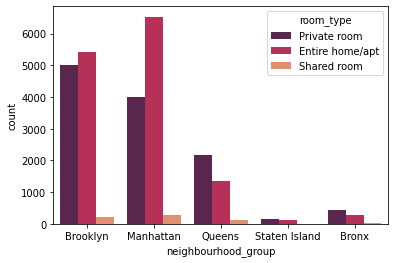

In [14]:
# We plot the type of housings available per nieghborhoud group.
sns.countplot(x = 'neighbourhood_group', data = raw_data, hue = 'room_type', palette = 'rocket')

We finally investigate correlations between the exogenous variables, we find a small correlation between the number of reviews and the reviews per month, however between the other variables there is almost none. So we can proceed with the prediction tasks, without any problem !  

<AxesSubplot:>

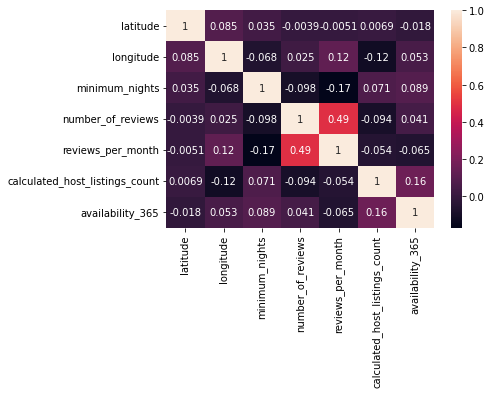

In [15]:
# We plot the correlation
sns.heatmap(raw_data.drop(columns=["price", "log_price", "neighbourhood_group", "id"]).corr(), annot=True)

## Neighbourhood Groups Classification


Usually, for this kind of tasks, we would not use models to predict as the relationship between longitude, lattitude and the neighbourhood is deterministic.  
However, for the sake of the exercise we predict this using a KNN and the haversine distance explained in this [link](https://stackoverflow.com/questions/37324332/how-to-find-the-nearest-neighbors-for-latitude-and-longitude-point-on-python).  

In [16]:
# We define our features
FEATURES = ["longitude", "latitude"]

# We define our target
TARGET = ["neighbourhood_group"]

# We define our preprocessing
mapper = DataFrameMapper([(col,  LabelEncoder()) for col in TARGET], df_out=True)

# We apply our transformations
data = pd.concat([mapper.fit_transform(raw_data), raw_data[FEATURES].applymap(radians)], axis=1)

data


,neighbourhood_group,longitude,latitude
0,1,-1.291061,0.709433
1,2,-1.291260,0.711285
3,1,-1.290841,0.710090
5,2,-1.291107,0.711181
7,2,-1.291281,0.711482
...,...,...,...
48782,2,-1.290735,0.711763
48790,3,-1.288308,0.711240
48799,4,-1.294035,0.707588
48805,0,-1.290217,0.712232


While splitting our dataset into a train-test we stratify on the neighbourhood_group that way we keep the same sample distribution in both samples. 

In [17]:
# We split to a train and test data
df_train, df_test = train_test_split(
                        data, test_size=0.2, random_state=42069, stratify=data["neighbourhood_group"]
                    )

# We get the fetaures we want
X_train, X_test = df_train[FEATURES], df_test[FEATURES]
y_train, y_test = df_train[TARGET], df_test[TARGET]

As a metric for the cross validation we use the F1 score, given our mutliclass classification task is pretty unbalanced. Using the binary accuracy might be missleading !

In [18]:
# We run a startified K fold cross validation on the training set with K = 3 and macro f1 score.
results = [np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=k, weights="distance", metric="haversine"), X_train, y_train.values.ravel(), cv=3, scoring='f1_macro',  n_jobs=-1)) for k in tqdm(range(2, 30))]    

100%|██████████| 28/28 [02:25<00:00,  5.18s/it]


In [19]:
# We get our k for knn
K = np.argmax(results) + 2
K

2

<AxesSubplot:>

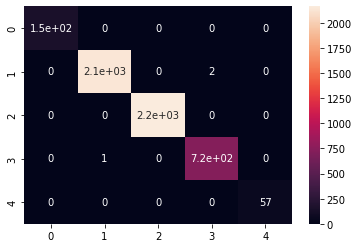

In [20]:
# We create our Jnn classifier with our optimal k
knn_model = KNeighborsClassifier(n_neighbors=K, weights="distance", metric="haversine")

# We train the Knn classifier 
knn_model.fit(X_train, y_train.values.ravel())

# We plot the results
sns.heatmap(confusion_matrix(knn_model.predict(X_test), y_test.values.ravel()), annot=True)

We obtain an almost perfect classification from the KNN model.

## Price regression

We start with a simple linear regression (Ordinary least squares) on the log price.
We rely mainly on the numerical values we have in our dataset but also on a one hot expansion of the neighbourhoods.    
This will allow us to have a lot of interpretability and infer the effect of the precise localisation on the price.

In [21]:
# We declare our features
SCALED_COLS = ["minimum_nights", "number_of_reviews", "reviews_per_month", "calculated_host_listings_count", "availability_365"]
BINARIZED_COLS = ["neighbourhood", "room_type"]

# We declare our target
TARGET = ["log_price"]

# We create our preprocessor
mapper = DataFrameMapper(  
                                [([col], OneHotEncoder()) for col in BINARIZED_COLS]
                                + [([col], MinMaxScaler()) for col in SCALED_COLS],
                        df_out=True,
                    )


# we add a constant for our regressor
data = sm.add_constant(pd.concat([raw_data[TARGET], mapper.fit_transform(raw_data)], axis=1))


data

/home/visium/Desktop/swisscom_assignment/env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/visium/Desktop/swisscom_assignment/env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,const,log_price,neighbourhood_x0_Allerton,neighbourhood_x0_Arden Heights,neighbourhood_x0_Arrochar,neighbourhood_x0_Arverne,neighbourhood_x0_Astoria,neighbourhood_x0_Bath Beach,neighbourhood_x0_Battery Park City,neighbourhood_x0_Bay Ridge,...,neighbourhood_x0_Woodlawn,neighbourhood_x0_Woodside,room_type_x0_Entire home/apt,room_type_x0_Private room,room_type_x0_Shared room,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,1.0,5.010635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.000000,0.012739,0.003419,0.015337,1.000000
1,1.0,5.420535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.000000,0.070064,0.006326,0.003067,0.972527
3,1.0,4.499810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.000000,0.428344,0.079159,0.000000,0.530220
5,1.0,5.303305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.001601,0.116242,0.009916,0.000000,0.351648
7,1.0,4.382027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.000801,0.683121,0.059155,0.000000,0.601648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48782,1.0,4.867534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.016926,0.000000,0.401099
48790,1.0,3.828641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.016926,0.015337,0.928571
48799,1.0,5.463832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.016926,0.000000,0.236264
48805,1.0,4.615121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.000000,0.001592,0.034023,0.000000,0.107143


In [22]:
# We train test split
X_train, X_test, y_train, y_test = train_test_split(
                        data.drop(columns=TARGET), data[TARGET], test_size=0.2, random_state=42069, stratify=raw_data["neighbourhood_group"]
                    )

# We remove non existing neighbourhoods in the training set
X_train = X_train.loc[:, (X_train != 0).any(axis=0)]
X_test = X_test.loc[:, X_train.columns]
X_train

,const,neighbourhood_x0_Allerton,neighbourhood_x0_Arden Heights,neighbourhood_x0_Arrochar,neighbourhood_x0_Arverne,neighbourhood_x0_Astoria,neighbourhood_x0_Bath Beach,neighbourhood_x0_Battery Park City,neighbourhood_x0_Bay Ridge,neighbourhood_x0_Bay Terrace,...,neighbourhood_x0_Woodlawn,neighbourhood_x0_Woodside,room_type_x0_Entire home/apt,room_type_x0_Private room,room_type_x0_Shared room,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
1247,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.004804,0.128981,0.016584,0.000000,0.109890
14344,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.023219,0.011146,0.003590,0.033742,0.046703
45786,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.010408,0.000000,0.016926,0.000000,0.002747
36888,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.000801,0.001592,0.004616,0.000000,0.142857
46546,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.001601,0.003185,0.051120,0.000000,0.725275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20874,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.000801,0.148089,0.055394,0.000000,0.456044
21720,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.000801,0.095541,0.036416,0.006135,0.112637
1468,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.000000,0.550955,0.072320,0.003067,0.675824
6969,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.000000,0.066879,0.013849,0.000000,0.065934


In [23]:
# We declare our Linear regression model
model = sm.OLS(y_train, X_train)

# We train the model 
model_results = model.fit()

# We look at our summary for fitting
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     127.6
Date:                Fri, 13 May 2022   Prob (F-statistic):               0.00
Time:                        10:44:38   Log-Likelihood:                -12642.
No. Observations:               20917   AIC:                         2.573e+04
Df Residuals:                   20696   BIC:                         2.748e+04
Df Model:                         220                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          3.1439      0.011    292.959      0.000       3.123       3.165
neighbourhood_x0_Allerton                     -0.0939      0.093     -1.008      0.313      -0.276       0.089
neighbourhood_x0_Arden Heights                -0.5365      0.314     -1.711      0.087      -1.151       0.078
neighbourhood_x0_Arrochar                     -0.1996      0.111     -1.792      0.073      -0.418       0.019
neighbourhood_x0_Arverne                       0.2105      0.063      3.337      0.001       0.087       0.334
neighbourhood_x0_Astoria                       0.0566      0.026      2.194      0.028       0.006       0.107
neighbourhood_x0_Bath Beach                   -0.1936      0.148     -1.307      0.191      -0.484       0.097
neighbourhood_x0_Battery Park City             0.3831      0.128      2.983      0.003       0.131       0.635
neighbourhood_x0_Bay Ridge                     0.0645      0.056      1.157      0.247      -0.045       0.174
neighbourhood_x0_Bay Terrace                   0.2386      0.199      1.202      0.229      -0.151       0.628
neighbourhood_x0_Baychester                   -0.1557      0.199     -0.784      0.433      -0.545       0.233
neighbourhood_x0_Bayside                       0.0150      0.105      0.143      0.887      -0.191       0.221
neighbourhood_x0_Bayswater                    -0.1156      0.148     -0.780      0.435      -0.406       0.175
neighbourhood_x0_Bedford-Stuyvesant            0.0237      0.015      1.531      0.126      -0.007       0.054
neighbourhood_x0_Belle Harbor                  0.1601      0.256      0.625      0.532      -0.342       0.662
neighbourhood_x0_Bellerose                    -0.0210      0.199     -0.106      0.916      -0.410       0.368
neighbourhood_x0_Belmont                      -0.1885      0.123     -1.526      0.127      -0.431       0.054
neighbourhood_x0_Bensonhurst                  -0.2377      0.073     -3.266      0.001      -0.380      -0.095
neighbourhood_x0_Bergen Beach                 -0.1860      0.168     -1.108      0.268      -0.515       0.143
neighbourhood_x0_Boerum Hill                   0.3961      0.055      7.203      0.000       0.288       0.504
neighbourhood_x0_Borough Park                 -0.1839      0.053     -3.461      0.001      -0.288      -0.080
neighbourhood_x0_Breezy Point                  1.1133      0.314      3.550      0.000       0.499       1.728
neighbourhood_x0_Briarwood                    -0.1412      0.082     -1.728      0.084      -0.301       0.019
neighbourhood_x0_Brighton Beach               -0.0836      0.070     -1.192      0.233      -0.221       0.054
neighbourhood_x0_Bronxdale                    -0.5153      0.157     -3.280      0.001

In [24]:
y_pred = model_results.predict(X_test)

pd.DataFrame([[r2_score(y_test, y_pred), mean_absolute_error(y_pred, y_test), mean_squared_error(y_pred, y_test)]], columns=["R^2", "mean absolute error", "mean squared error"], index=["test scores"])

,R^2,mean absolute error,mean squared error
test scores,0.570823,0.323881,0.198021


We see a reasonable performance of 0.57 R squared, 0.32 MAE and 0.198 MSE. Let's see if we can improve by adding regularization.  
Ideally, adding the L2 penalty will help us overfit less and will lower our variance.

In [25]:
# We declare our ridge model
model_ridge = RidgeCV(alphas=np.linspace(0.001, 20, 1000), fit_intercept=True)

# We train the model with K fold cross validation
model_ridge.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e-03, 2.10190190e-02, 4.10380380e-02, 6.10570571e-02,
       8.10760761e-02, 1.01095095e-01, 1.21114114e-01, 1.41133133e-01,
       1.61152152e-01, 1.81171171e-01, 2.01190190e-01, 2.21209209e-01,
       2.41228228e-01, 2.61247247e-01, 2.81266266e-01, 3.01285285e-01,
       3.21304304e-01, 3.41323323e-01, 3.61342342e-01, 3.81361361e-01,
       4.01380380e-01, 4.21399399e-0...
       1.95395626e+01, 1.95595816e+01, 1.95796006e+01, 1.95996196e+01,
       1.96196386e+01, 1.96396577e+01, 1.96596767e+01, 1.96796957e+01,
       1.96997147e+01, 1.97197337e+01, 1.97397528e+01, 1.97597718e+01,
       1.97797908e+01, 1.97998098e+01, 1.98198288e+01, 1.98398478e+01,
       1.98598669e+01, 1.98798859e+01, 1.98999049e+01, 1.99199239e+01,
       1.99399429e+01, 1.99599620e+01, 1.99799810e+01, 2.00000000e+01]))

In [26]:
# We compute the R squared on training set, print the optimal alpha
model_ridge.score(X_train, y_train), model_ridge.alpha_

(0.5748242357476073, 1.5825025025025024)

In [27]:
# We predict our test samples
y_pred = model_ridge.predict(X_test)

# We print the resultss
pd.DataFrame([[r2_score(y_test, y_pred), mean_absolute_error(y_pred, y_test), mean_squared_error(y_pred, y_test)]], columns=["R^2", "mean absolute error", "mean squared error"], index=[f"test scores for alpha {model_ridge.alpha_}"])

,R^2,mean absolute error,mean squared error
test scores for alpha 1.5825025025025024,0.56981,0.324475,0.198488


We now explore the relationship we have between the precise location and the neighbourhood.
We rely mainly on OLS coefficients and their p values and confidence intervals for determining how sure we are of the coefficient.

In [28]:
# We get our betas and their p values
df = pd.DataFrame([model_results.params.tolist(), model_results.pvalues.tolist()], columns=X_train.columns, index=["Coefficients", "Pvalues"])

# We get their confidence intervals
df = pd.concat([df, model_results.conf_int().T.set_index(keys=pd.Index(["low", "high"]))])

In [29]:
# We select only the neighbourhood parameters
cols = list(filter(lambda x: x.startswith("neighbourhood"), list(df.columns)))


# We print our final data frame
df = df[cols].T.reset_index().rename(columns={"index":"neighbourhood"})
df["neighbourhood"] = df["neighbourhood"].str.split("_").apply(lambda x: x[-1])
df["significance"] = df["Pvalues"].apply(lambda x: "significant" if x < 0.05 else "no affirmation")
df

,neighbourhood,Coefficients,Pvalues,low,high,significance
0,Allerton,-0.093884,0.313345,-0.276397,0.088630,no affirmation
1,Arden Heights,-0.536471,0.087124,-1.151093,0.078151,no affirmation
2,Arrochar,-0.199583,0.073166,-0.417900,0.018734,no affirmation
3,Arverne,0.210528,0.000848,0.086867,0.334188,significant
4,Astoria,0.056625,0.028255,0.006034,0.107215,significant
...,...,...,...,...,...,...
209,Willowbrook,0.508674,0.251211,-0.360248,1.377597,no affirmation
210,Windsor Terrace,0.072394,0.175950,-0.032453,0.177241,no affirmation
211,Woodhaven,-0.289377,0.000006,-0.414341,-0.164413,significant
212,Woodlawn,-0.446740,0.013728,-0.802042,-0.091437,significant


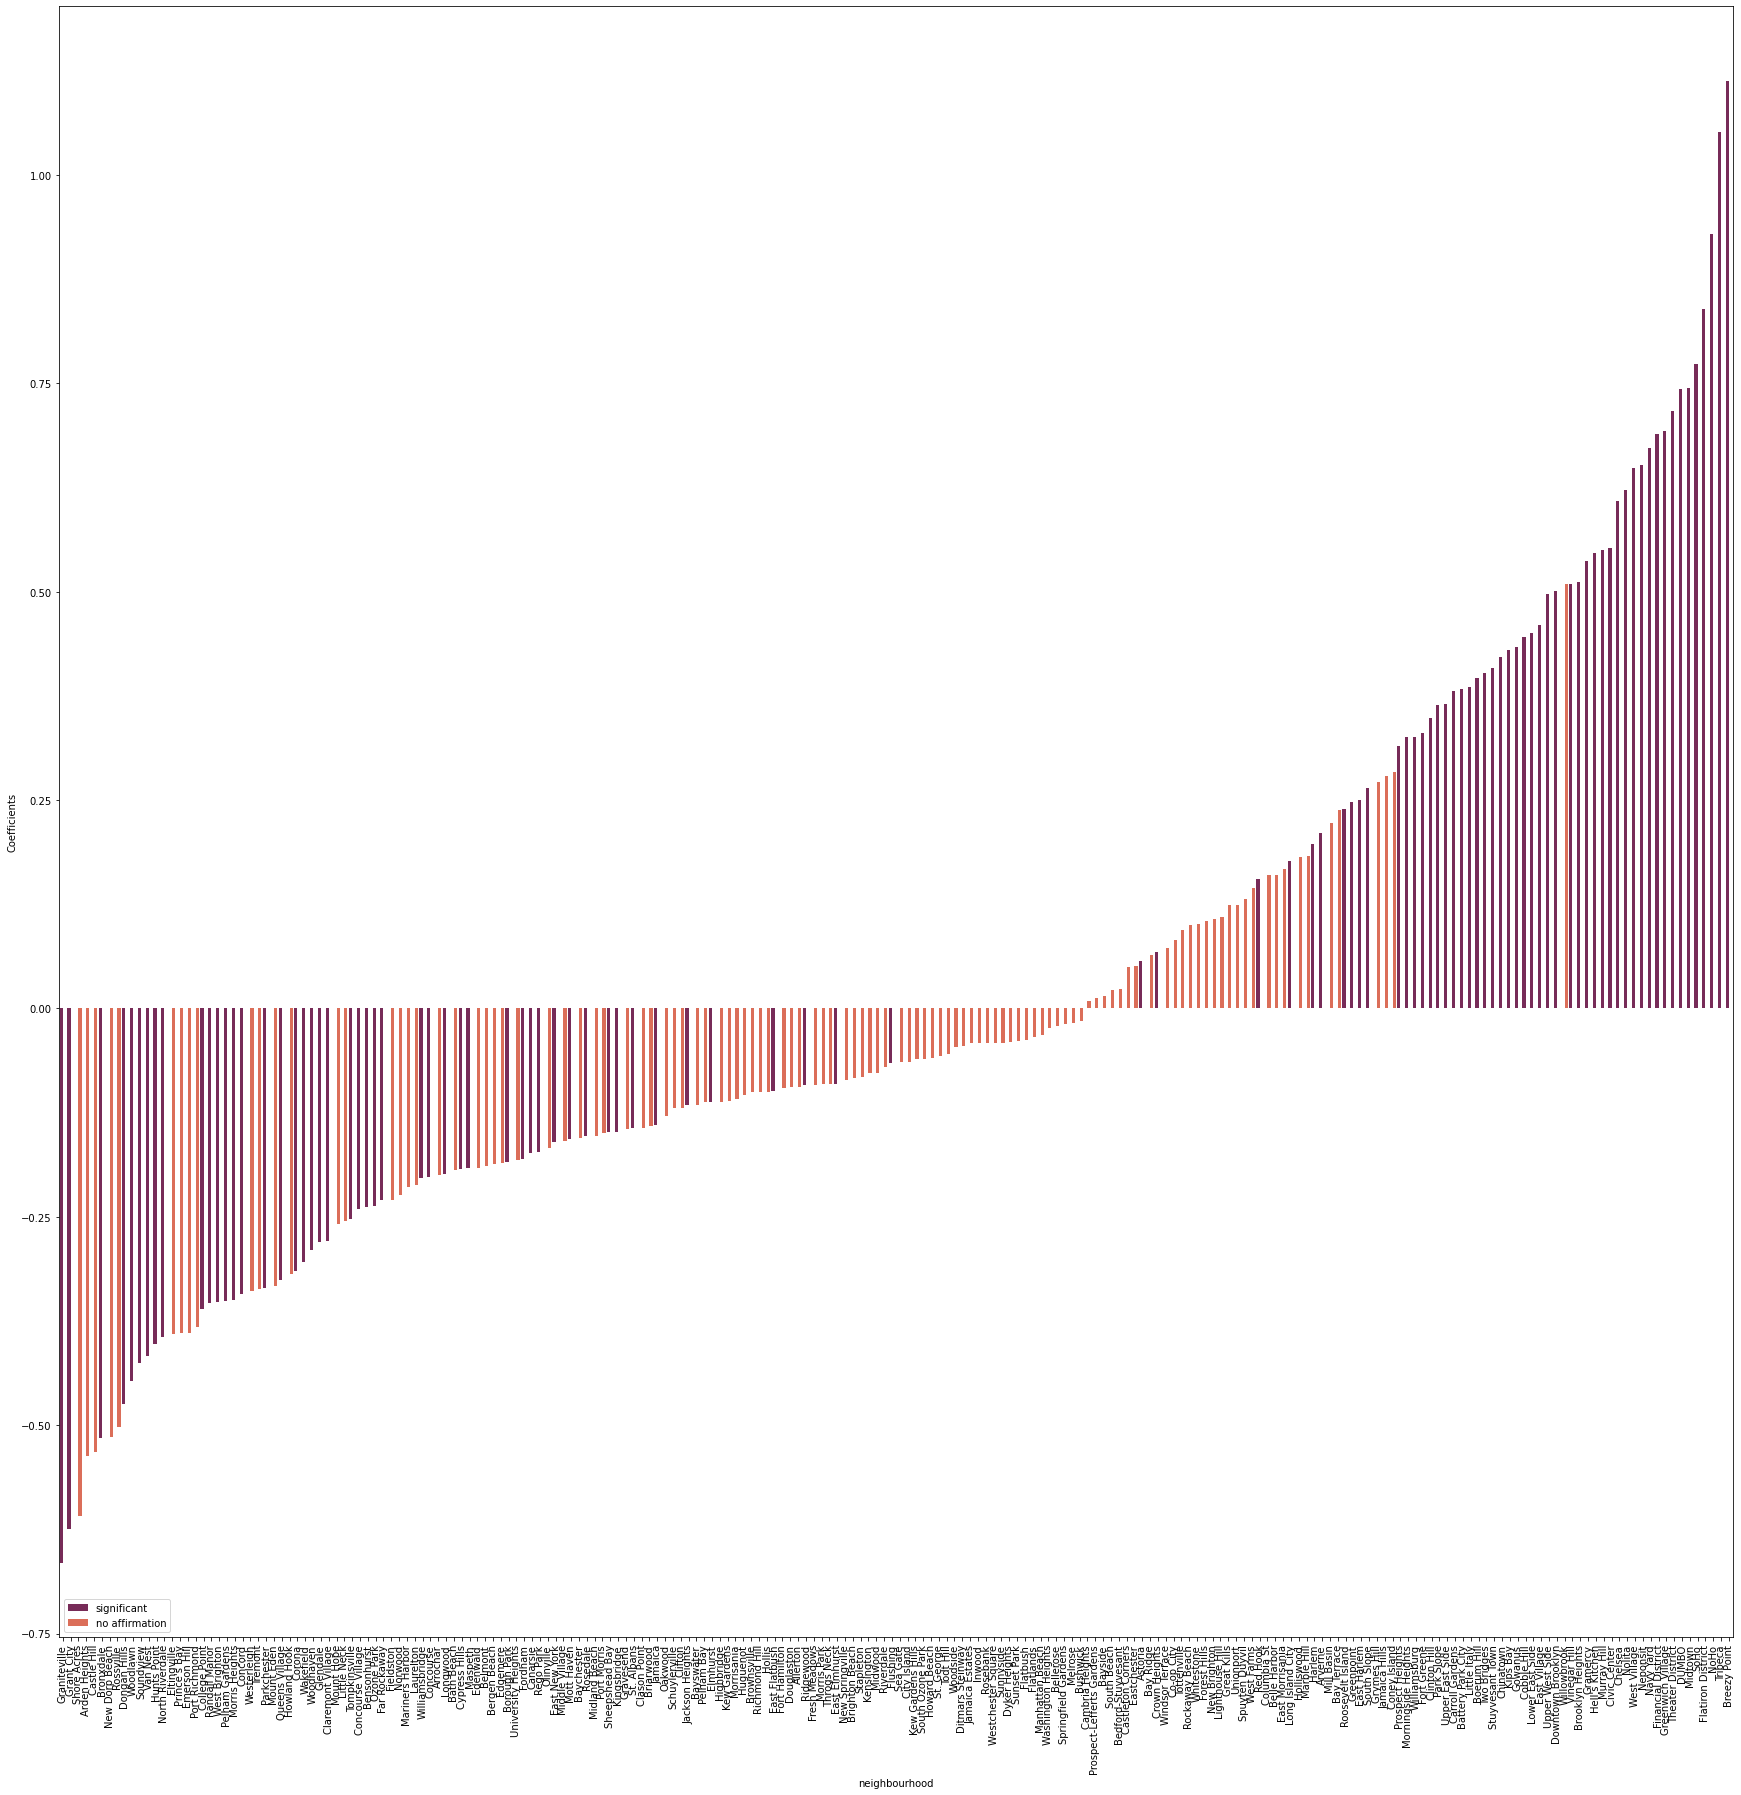

In [30]:
# We plot the previous dataframe sorted by importance 
plt.figure(figsize=(30, 30))
sns.barplot(x = 'neighbourhood', y = "Coefficients", data = df.sort_values(["Coefficients"]), hue = 'significance', palette = 'rocket', orient= "v")
plt.xticks(rotation=90)
plt.legend()


In [31]:
raw_data.merge(df, on="neighbourhood")

,id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,log_price,Coefficients,Pvalues,low,high,significance
0,2539,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,5.010635,-0.077207,0.162934,-0.185662,0.031249,no affirmation
1,63546,Brooklyn,Kensington,40.64106,-73.97426,Private room,39,1,45,2019-05-16,0.46,2,365,3.688879,-0.077207,0.162934,-0.185662,0.031249,no affirmation
2,125594,Brooklyn,Kensington,40.64302,-73.97255,Private room,39,1,82,2019-05-19,0.94,2,365,3.688879,-0.077207,0.162934,-0.185662,0.031249,no affirmation
3,267652,Brooklyn,Kensington,40.64277,-73.97296,Private room,60,2,20,2019-01-21,0.42,1,347,4.110874,-0.077207,0.162934,-0.185662,0.031249,no affirmation
4,282341,Brooklyn,Kensington,40.64330,-73.97386,Entire home/apt,90,30,3,2017-07-30,0.05,1,286,4.510860,-0.077207,0.162934,-0.185662,0.031249,no affirmation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26139,32306527,Queens,Jamaica Hills,40.71686,-73.79742,Private room,67,2,25,2019-07-07,6.88,2,318,4.219508,0.279170,0.159834,-0.110104,0.668444,no affirmation
26140,33469440,Queens,Jamaica Hills,40.71022,-73.79665,Entire home/apt,110,2,8,2019-06-29,3.16,1,81,4.709530,0.279170,0.159834,-0.110104,0.668444,no affirmation
26141,33957835,Queens,Jamaica Hills,40.71757,-73.79610,Private room,65,1,1,2019-07-07,1.00,2,139,4.189655,0.279170,0.159834,-0.110104,0.668444,no affirmation
26142,35057815,Queens,Jamaica Hills,40.71209,-73.80151,Entire home/apt,325,2,4,2019-07-08,4.00,2,124,5.786897,0.279170,0.159834,-0.110104,0.668444,no affirmation


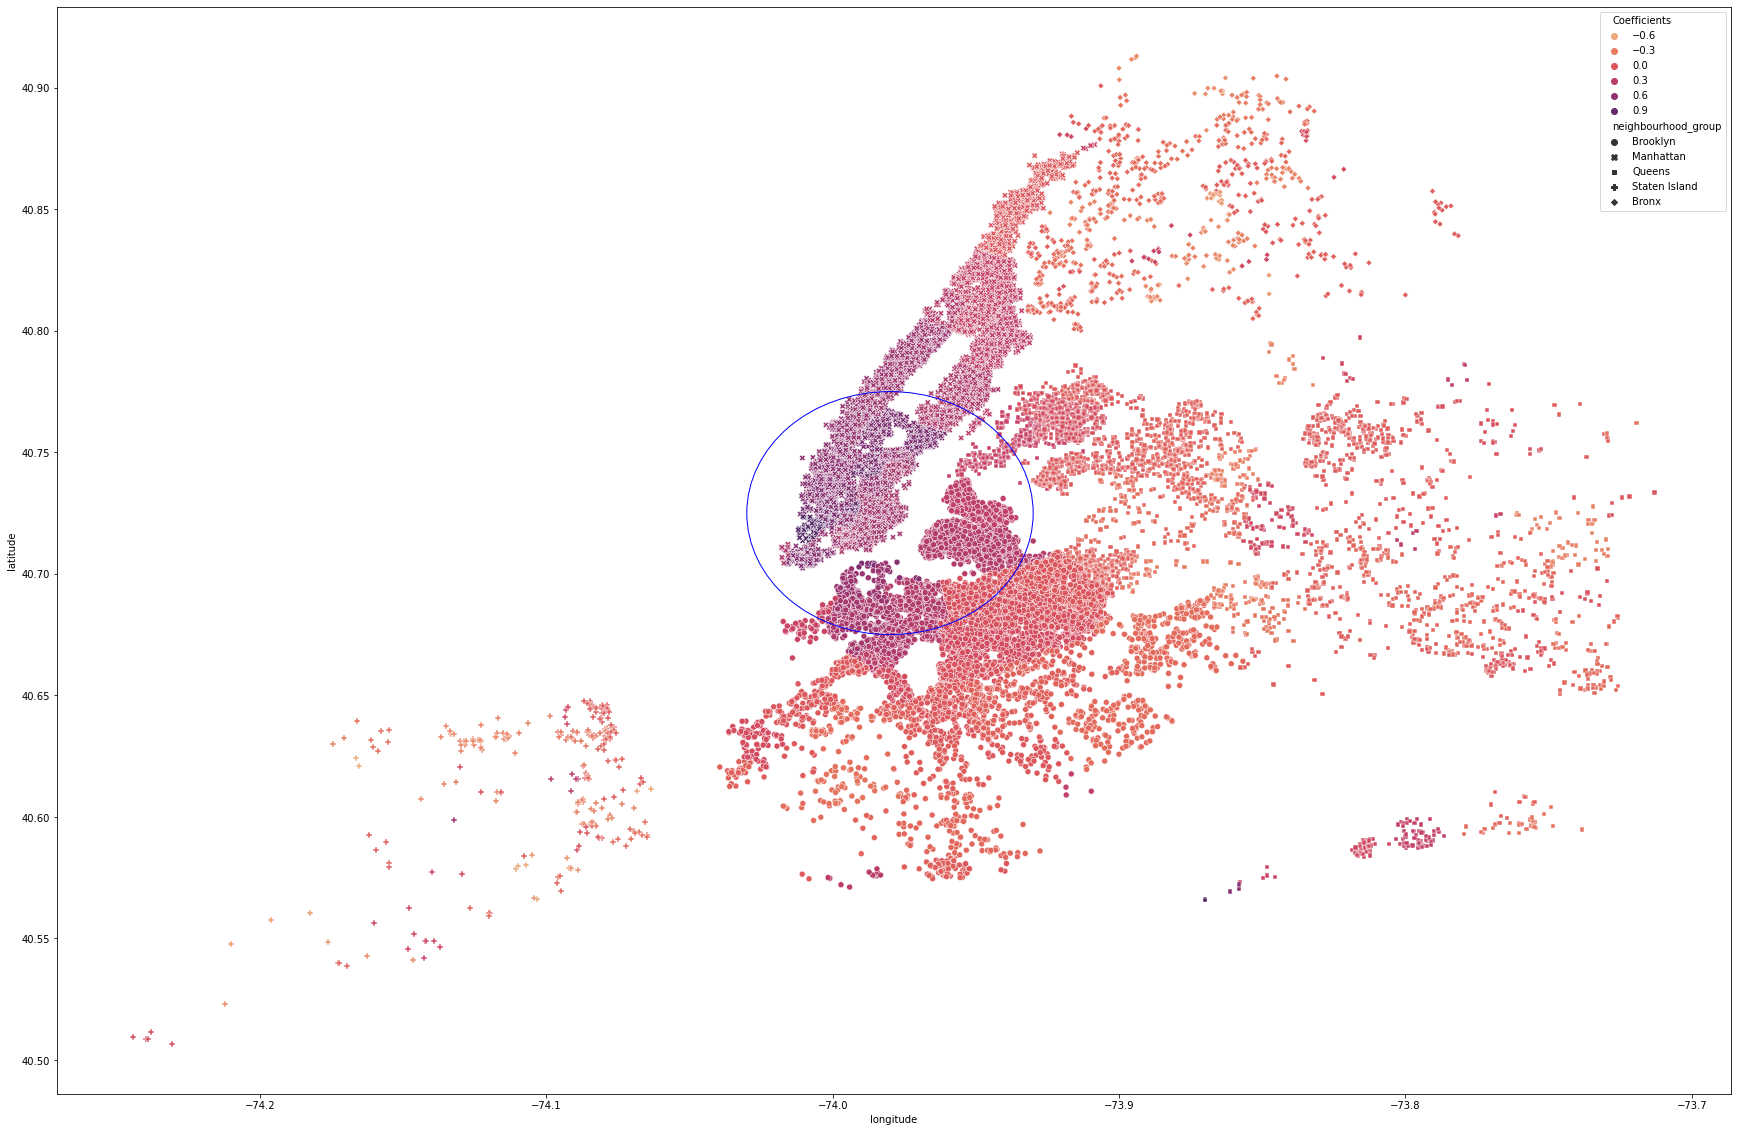

In [32]:

df_plot = raw_data.merge(df, on="neighbourhood")
fig, ax = plt.subplots(1, figsize=(30, 20))

#ax[0] = sns.scatterplot(data=df_plot, x="longitude", y="latitude", hue="neighbourhood_group")
ax = sns.scatterplot(data=df_plot, x="longitude", y="latitude", hue="Coefficients", style="neighbourhood_group", palette=sns.color_palette("flare", as_cmap=True))

c = plt.Circle((-73.98, 40.725), 0.05, color='b', fill=False)
ax.add_patch(c)


We can clearly see that the location is indeed very important as we see a higher concentration of high coefficients in the center. Exploring the coefficients as well we can see that a lot of them are statistically significant (p value < 0.05) and sometimes their weight can even reach more than 1 in terms of absolute value. 

We now attempt to go further in the analysis and try and predict with lower error the price. For that, and given the number of binary variables we have, we opt for a tree based method. We decide to go with XGBoost as they are one of the most powerful tree ensemble method there is. 

In [33]:
# We declare our XGB model
model_XGB = GradientBoostingRegressor(max_features="log2")

# We declare our hyperparameters to optimize
param_grid = {
    "n_estimators": [100, 150, 200],
    "max_depth" : [1, 3, 15, 30]
}

# We declare our grid search model
XGB_grid_model = GridSearchCV(estimator = model_XGB, param_grid = param_grid,
                             scoring = 'r2', cv = 3, n_jobs=-1, verbose=10,)

# We train our XGB model with the grid searchon the hyperparameters
XGB_grid_model.fit(X_train, y_train.values.ravel())

# We score our training model
XGB_grid_model.score(X_train, y_train.values.ravel())

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3; 1/12] START max_depth=1, n_estimators=100..............................
[CV 1/3; 2/12] START max_depth=1, n_estimators=150..............................[CV 3/3; 1/12] START max_depth=1, n_estimators=100..............................

[CV 2/3; 2/12] START max_depth=1, n_estimators=150..............................
[CV 3/3; 2/12] START max_depth=1, n_estimators=150..............................
[CV 1/3; 3/12] START max_depth=1, n_estimators=200..............................
[CV 2/3; 1/12] START max_depth=1, n_estimators=100..............................
[CV 2/3; 3/12] START max_depth=1, n_estimators=200..............................
[CV 3/3; 1/12] END max_depth=1, n_estimators=100;, score=0.362 total time=   1.0s
[CV 3/3; 3/12] START max_depth=1, n_estimators=200..............................
[CV 1/3; 2/12] END max_depth=1, n_estimators=150;, score=0.445 total time=   1.3s
[CV 1/3; 4/12] START max_depth=3, n_estimators

0.8686812329702867

In [34]:
# We predict our test sample
y_pred = XGB_grid_model.predict(X_test)

# We print our metrics
pd.DataFrame([[r2_score(y_test, y_pred), mean_absolute_error(y_pred, y_test), mean_squared_error(y_pred, y_test)]], columns=["R^2", "mean absolute error", "mean squared error"], index=[f"test scores"])

,R^2,mean absolute error,mean squared error
test scores,0.616606,0.305816,0.176896


Indeed we can clearly see a clear increase in performance compared to the linear models. One nice property of tree methods, is that they offer some kind off interpretability given the splits performed. 

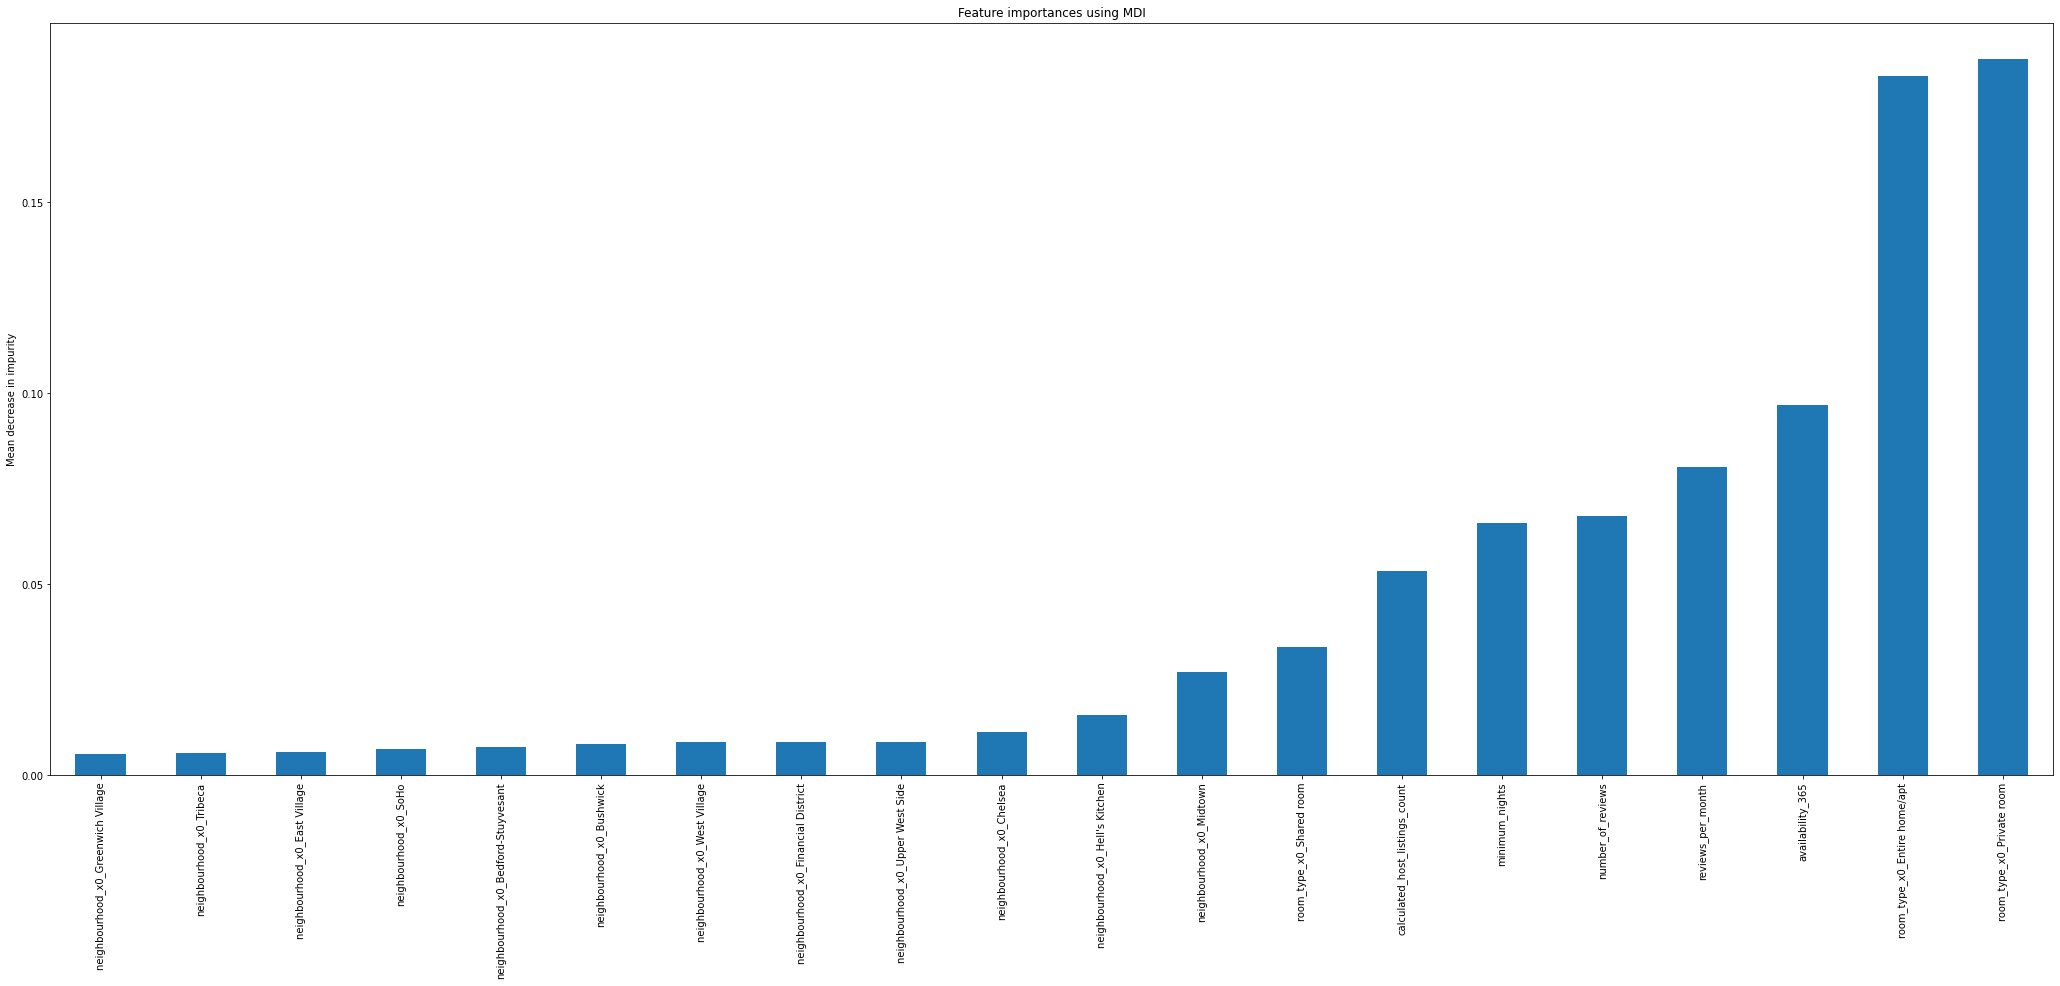

In [35]:
importances = XGB_grid_model.best_estimator_.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns).sort_values().iloc[-20:]
fig, ax = plt.subplots(figsize=(30, 15))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.rcParams.update({'font.size': 50})
fig.tight_layout()

Although this approach gives us insight, it is far from ideal for many reasons. One that might concern is that due to the nature of the splits, impurity-based feature importance for trees are strongly biased typically numerical features over  features such as binary features or categorical variables with a small number of possible categories. 

Although we are able to predict the price to some extend thanks to the features we have. This problem has a main component which is locality. Very close housings might have similar prices, using linear models or models that in general rely on solely the features make us lose this important component of locality, which may provided by a model such as a graph neural network.  
In our case, because of the lack of time, we can attempt to add this notion, by adding the price of the three closest neighbours (from the training set) using the haversine distance to our set of features. 

In [68]:
SCALED_COLS = ["minimum_nights", "number_of_reviews", "reviews_per_month", "calculated_host_listings_count", "availability_365"]
BINARIZED_COLS = ["neighbourhood", "room_type"]
TARGET = ["log_price"]
FEATURES = SCALED_COLS


mapper = DataFrameMapper(  
                                [([col], OneHotEncoder()) for col in BINARIZED_COLS]
                                + [([col], MinMaxScaler()) for col in SCALED_COLS],
                        df_out=True,
                    )


data = pd.concat([raw_data[["longitude", "latitude"]], mapper.fit_transform(raw_data)], axis=1)

data[TARGET] = raw_data[TARGET].copy()

data

/home/visium/Desktop/swisscom_assignment/env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/visium/Desktop/swisscom_assignment/env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/tmp/ipykernel_189632/4047112347.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[TARGET] = raw_data[TARGET].copy()


,longitude,latitude,neighbourhood_x0_Allerton,neighbourhood_x0_Arden Heights,neighbourhood_x0_Arrochar,neighbourhood_x0_Arverne,neighbourhood_x0_Astoria,neighbourhood_x0_Bath Beach,neighbourhood_x0_Battery Park City,neighbourhood_x0_Bay Ridge,...,neighbourhood_x0_Woodside,room_type_x0_Entire home/apt,room_type_x0_Private room,room_type_x0_Shared room,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,log_price
0,-73.97237,40.64749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.000000,0.012739,0.003419,0.015337,1.000000,5.010635
1,-73.98377,40.75362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.000000,0.070064,0.006326,0.003067,0.972527,5.420535
3,-73.95976,40.68514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.000000,0.428344,0.079159,0.000000,0.530220,4.499810
5,-73.97500,40.74767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.001601,0.116242,0.009916,0.000000,0.351648,5.303305
7,-73.98493,40.76489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.000801,0.683121,0.059155,0.000000,0.601648,4.382027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48782,-73.95366,40.78099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.000000,0.000000,0.016926,0.000000,0.401099,4.867534
48790,-73.81459,40.75104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.000000,0.000000,0.016926,0.015337,0.928571,3.828641
48799,-74.14275,40.54179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.000000,0.000000,0.016926,0.000000,0.236264,5.463832
48805,-73.92400,40.80787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.000000,0.001592,0.034023,0.000000,0.107143,4.615121


In [37]:
X_train, X_test, y_train, y_test = train_test_split(
                        data.drop(columns=TARGET), data[TARGET], test_size=0.2, random_state=42069, stratify=raw_data["neighbourhood_group"]
                    )



data[["neighbour_price_1", "neighbour_price_2", "neighbour_price_3"]] = [np.argsort(haversine_distances(x.values.reshape(-1, 2), X_train[["longitude", "latitude"]].values)).flatten()[1:4] for _, x in tqdm(data[["longitude", "latitude"]].iterrows())] 

26147it [03:59, 109.16it/s]


In [38]:
data[["neighbour_price_1", "neighbour_price_2", "neighbour_price_3", "log_price"]]

,neighbour_price_1,neighbour_price_2,neighbour_price_3,log_price
0,13687,16071,8115,5.010635
1,210,5205,16195,5.420535
3,18324,6605,8048,4.499810
5,12202,8738,2895,5.303305
7,17788,984,5640,4.382027
...,...,...,...,...
48782,20545,17299,12012,4.867534
48790,11302,19807,10724,3.828641
48799,10924,8033,16024,5.463832
48805,2360,9974,14900,4.615121


In [39]:
data[["neighbour_price_1", "neighbour_price_2", "neighbour_price_3"]] = data[["neighbour_price_1", "neighbour_price_2", "neighbour_price_3"]].applymap(lambda x: y_train["log_price"].iloc[x].item())

In [40]:
data[["neighbour_price_1", "neighbour_price_2", "neighbour_price_3", "log_price"]]

,neighbour_price_1,neighbour_price_2,neighbour_price_3,log_price
0,3.828641,5.525453,3.931826,5.010635
1,4.615121,6.398595,7.601402,5.420535
3,4.564348,5.351858,4.941642,4.499810
5,5.351858,4.795791,5.017280,5.303305
7,5.198497,5.017280,5.634790,4.382027
...,...,...,...,...
48782,4.700480,5.170484,5.198497,4.867534
48790,4.189655,3.828641,4.262680,3.828641
48799,3.713572,3.931826,4.795791,5.463832
48805,3.912023,4.753590,4.615121,4.615121


In [41]:
X_train, X_test, y_train, y_test = train_test_split(
                        data.drop(columns=TARGET+["longitude", "latitude"]), data[TARGET], test_size=0.2, random_state=42069, stratify=raw_data["neighbourhood_group"]
                    )

X_train = X_train.loc[:, (X_train != 0).any(axis=0)]
X_test = X_test.loc[:, X_train.columns]

In [42]:
X_train

,neighbourhood_x0_Allerton,neighbourhood_x0_Arden Heights,neighbourhood_x0_Arrochar,neighbourhood_x0_Arverne,neighbourhood_x0_Astoria,neighbourhood_x0_Bath Beach,neighbourhood_x0_Battery Park City,neighbourhood_x0_Bay Ridge,neighbourhood_x0_Bay Terrace,neighbourhood_x0_Baychester,...,room_type_x0_Private room,room_type_x0_Shared room,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbour_price_1,neighbour_price_2,neighbour_price_3
1247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.004804,0.128981,0.016584,0.000000,0.109890,5.303305,5.690359,5.105945
14344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.023219,0.011146,0.003590,0.033742,0.046703,5.135798,6.216606,5.521461
45786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.010408,0.000000,0.016926,0.000000,0.002747,5.303305,4.836282,2.397895
36888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000801,0.001592,0.004616,0.000000,0.142857,5.198497,4.941642,5.420535
46546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.001601,0.003185,0.051120,0.000000,0.725275,4.615121,5.298317,4.615121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.000801,0.148089,0.055394,0.000000,0.456044,4.394449,6.746412,5.017280
21720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.000801,0.095541,0.036416,0.006135,0.112637,4.521789,4.499810,4.510860
1468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.000000,0.550955,0.072320,0.003067,0.675824,4.615121,3.828641,5.049856
6969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.000000,0.066879,0.013849,0.000000,0.065934,5.525453,3.637586,3.555348


In [43]:
model_ridge = RidgeCV(alphas=np.linspace(0.001, 20, 1000), fit_intercept=True)

model_ridge.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000000e-03, 2.10190190e-02, 4.10380380e-02, 6.10570571e-02,
       8.10760761e-02, 1.01095095e-01, 1.21114114e-01, 1.41133133e-01,
       1.61152152e-01, 1.81171171e-01, 2.01190190e-01, 2.21209209e-01,
       2.41228228e-01, 2.61247247e-01, 2.81266266e-01, 3.01285285e-01,
       3.21304304e-01, 3.41323323e-01, 3.61342342e-01, 3.81361361e-01,
       4.01380380e-01, 4.21399399e-0...
       1.95395626e+01, 1.95595816e+01, 1.95796006e+01, 1.95996196e+01,
       1.96196386e+01, 1.96396577e+01, 1.96596767e+01, 1.96796957e+01,
       1.96997147e+01, 1.97197337e+01, 1.97397528e+01, 1.97597718e+01,
       1.97797908e+01, 1.97998098e+01, 1.98198288e+01, 1.98398478e+01,
       1.98598669e+01, 1.98798859e+01, 1.98999049e+01, 1.99199239e+01,
       1.99399429e+01, 1.99599620e+01, 1.99799810e+01, 2.00000000e+01]))

In [44]:
y_pred = model_ridge.predict(X_test)

pd.DataFrame([[r2_score(y_test, y_pred), mean_absolute_error(y_pred, y_test), mean_squared_error(y_pred, y_test)]], columns=["R^2", "mean absolute error", "mean squared error"], index=["test scores"])

,R^2,mean absolute error,mean squared error
test scores,0.5733,0.323678,0.196877


We only see a slight increase in performance, thus we could not leverage it due the dataset not being very populated to the point where closeness matters, or simply due to the  limited expressivity of the linear model that cannot leverage them. 


As a last step, we try and predict both at the same time. Thus to implement this challenge, we build a small neura lnetwork with one hidden layer.  
This neural network has one hidden layer and after each layer, has a batch norm (Due to the usage of a ReLU as an activation function, it allows us to recenter the means) and Dropout as a mean of stabilizing and regularizing the learning. 

In [45]:
SCALED_COLS = ["minimum_nights", "number_of_reviews", "reviews_per_month", "calculated_host_listings_count", "availability_365", "longitude", "latitude"]
BINARIZED_COLS = ["neighbourhood", "room_type"]
TARGET = ["log_price", "neighbourhood_group"]
FEATURES = SCALED_COLS


mapper_input = DataFrameMapper(  
                                [([col], OneHotEncoder()) for col in BINARIZED_COLS]
                                + [([col], MinMaxScaler()) for col in SCALED_COLS],
                        df_out=True,
                    )

mapper_output = DataFrameMapper(  
                                [([col], OneHotEncoder()) for col in ["neighbourhood_group"]],
                        df_out=True,
                    )


data_in = mapper_input.fit_transform(raw_data)

data_out = pd.concat([raw_data["log_price"], mapper_output.fit_transform(raw_data)], axis=1)

data_out

/home/visium/Desktop/swisscom_assignment/env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/visium/Desktop/swisscom_assignment/env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/visium/Desktop/swisscom_assignment/env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,log_price,neighbourhood_group_x0_Bronx,neighbourhood_group_x0_Brooklyn,neighbourhood_group_x0_Manhattan,neighbourhood_group_x0_Queens,neighbourhood_group_x0_Staten Island
0,5.010635,0.0,1.0,0.0,0.0,0.0
1,5.420535,0.0,0.0,1.0,0.0,0.0
3,4.499810,0.0,1.0,0.0,0.0,0.0
5,5.303305,0.0,0.0,1.0,0.0,0.0
7,4.382027,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
48782,4.867534,0.0,0.0,1.0,0.0,0.0
48790,3.828641,0.0,0.0,0.0,1.0,0.0
48799,5.463832,0.0,0.0,0.0,0.0,1.0
48805,4.615121,1.0,0.0,0.0,0.0,0.0


In [60]:
X_train, X_test, y_train, y_test = train_test_split(
                        data_in, data_out, test_size=0.2, random_state=42069, stratify=raw_data["neighbourhood_group"]
                    )



In [61]:
from utils_2 import SimpleNeuralNetwork

output =  ["log_price"] + raw_data["neighbourhood_group"].drop_duplicates().tolist()
print(output)
neural_network = SimpleNeuralNetwork(X_train.shape[1], 300, len(output))
neural_network

['log_price', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx']


SimpleNeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=227, out_features=300, bias=True)
    (1): Linear(in_features=300, out_features=6, bias=True)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

To train this neural network on two different tasks we combine two loasses, The cross entropy loss for the classification task and the L1 loss for the regression task.  
We rely on Adam as an optimizer with lr: 0.001 and decay with a factor 0.99 every epoch. 
Let us explore the results.

In [62]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch import nn, from_numpy, sqrt



X_train = from_numpy(X_train.values).float()
y_train = from_numpy(y_train.values).float()
trainloader = DataLoader(list(zip(X_train, y_train)), batch_size=128,
                                          shuffle=True, num_workers=2)
criterion_classification = nn.CrossEntropyLoss()
criterion_regression = nn.L1Loss()
optimizer = optim.Adam(neural_network.parameters(), lr=0.001)
lr_decay = optim.lr_scheduler.ExponentialLR(optimizer, 0.99)

In [63]:
try:
    for epoch in range(200):  # loop over the dataset multiple times
        neural_network.train()
        running_loss_reg = 0.0
        running_loss_clf = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = neural_network(inputs)
            loss_reg = criterion_regression(outputs[:, 0], labels[:, 0]) 
            loss_clf = criterion_classification(outputs[:, 1:], labels[:, 1:])
            loss = loss_reg + loss_clf
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss_reg += loss_reg.item()
            running_loss_clf += loss_clf.item()
            if i % 10 == 9:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss regression: {running_loss_reg / 10:.3f}, loss classification: {running_loss_clf / 10:.3f}')
                running_loss_reg = running_loss_clf = 0.0
        if epoch > 100:
            lr_decay.step()
except KeyboardInterrupt:
    pass
                
        

print('Finished Training')

[1,    10] loss regression: 4.067, loss classification: 1.295
[1,    20] loss regression: 2.988, loss classification: 0.702
[1,    30] loss regression: 1.727, loss classification: 0.476
[1,    40] loss regression: 0.821, loss classification: 0.364
[1,    50] loss regression: 0.728, loss classification: 0.275
[1,    60] loss regression: 0.626, loss classification: 0.227
[1,    70] loss regression: 0.636, loss classification: 0.162
[1,    80] loss regression: 0.616, loss classification: 0.158
[1,    90] loss regression: 0.602, loss classification: 0.106
[1,   100] loss regression: 0.593, loss classification: 0.101
[1,   110] loss regression: 0.579, loss classification: 0.088
[1,   120] loss regression: 0.601, loss classification: 0.067
[1,   130] loss regression: 0.580, loss classification: 0.069
[1,   140] loss regression: 0.572, loss classification: 0.051
[1,   150] loss regression: 0.583, loss classification: 0.052
[1,   160] loss regression: 0.547, loss classification: 0.038
[2,    1

In [64]:
neural_network.eval()

y_pred = neural_network(from_numpy(X_test.values))
y_pred = y_pred.detach().numpy()
y_testt = y_test.values[:, 0]
pd.DataFrame([[r2_score(y_testt, y_pred[:, 0]), mean_absolute_error(y_pred[:, 0], y_testt), mean_squared_error(y_pred[:, 0], y_testt)]], columns=["R^2", "mean absolute error", "mean squared error"], index=["test scores"])

,R^2,mean absolute error,mean squared error
test scores,0.574611,0.317342,0.196273


<AxesSubplot:>

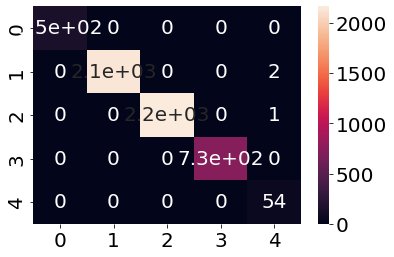

In [67]:
from sklearn.metrics import confusion_matrix

y_pred = neural_network(from_numpy(X_test.values))
y_pred = y_pred.detach().numpy()
conf_matrix = confusion_matrix(np.argmax(y_pred[:, 1:], axis=1), np.argmax(y_test.values[:, 1:], axis=1))
plt.rcParams.update({'font.size': 20})
sns.heatmap(conf_matrix, annot=True)


In [66]:
from sklearn.metrics import f1_score


f1_score(np.argmax(y_pred[:, 1:], axis=1), np.argmax(y_test.values[:, 1:], axis=1), average="macro")

0.9944546085433595

Best we can reach with the limited time and computational power is the Ridge Regression performance for the price and an almost perfect performance for the classification. 
Ideally, with more computational power and time we can fine tune the model to reach a better performance and try and reach the XBG performance, by scheduelling better the learning rate and studying more deeply the architecture(for example not back propagating on the same inputs for both tasks, adding locality with gnn, etc..).

Thanks :)